# 2. Preprocessing
We will address every single point that is mentioned in the Preprocessing slides. We won't have to code everyone but at least state why we are doing it or why not. We are addressing the following:

Errors, Missing Values, Unbalanced distribution, Different Scales, False Predictors, Unsupported data types (Categorical data and Dates, Textual values), High Dimensionality (Feature Subset Selection, PCA, Sampling)

## Agenda
In this Notebook the following Data Preparation steps will be performed:
- Set Working Environment
    - Packages
    - Working Directory
- Data Exploration
    - Load Raw Dataset
    - Check Features
    - Check Data Types
- Data Preparation
    - Remove Irrelevant Features 
    - Remove outliers (Length, Tempo, Time signature)
    - Irrelevant/Redundant Features, False Predictors
    - Missing Values
- Data Engineering
    - Boolean Values
    - Multi-Hot Encoding for track_genre
    - One Hot Encoding for time_signature and key
    - Sentiment Analysis on track_title
- Save clean data set
    - Sanity Check
    - Save preprocessed data
    - Create and save version without popularity score zero

## Set Working Environment

### Packages

Make sure, that we use the packages that were referenced in the slides (Preprocessing, slide 70):
- scikit-learn Imputation
- scikit-learn Preprocessing
- scikit-learn Text feature extraction
- scikit-learn Feature Selection

In [44]:
# import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from utils_io import load_step, save_step
import sys, site, platform
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

### Working Directory

In [15]:
# check working directory
print(sys.executable)
print(platform.python_version())
print(pd.__version__)

/Users/clari/datamining_group12/venv/bin/python
3.14.0
2.3.3


## Data Exploration

In [16]:
# Load the dataset
print(os.getcwd())
df = pd.read_csv('data/Spotify_Songs.csv')

# General Info
print('Dataset Info:')
df.info()

/Users/clari/datamining_group12
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   index             114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  1140

In [4]:
# check columns

In [5]:
# check data types

genre__Pop                                0.092566
genre__Soundtrack_Showtunes               0.092544
genre__Rock                               0.088305
loudness                                  0.067570
time_signature_4                          0.062891
danceability                              0.061007
explicit                                  0.055091
genre__Folk_Acoustic_Singer-Songwriter    0.041592
genre__World_International                0.038436
genre__Hip-Hop_Rap                        0.023993
genre__R&B_Soul_Funk                      0.021224
key_4                                     0.012274
energy                                    0.011884
key_11                                    0.009186
key_2                                     0.008012
key_8                                     0.007239
sentiment_neutral                         0.006902
tempo                                     0.006439
genre__Latin                              0.005537
key_6                          

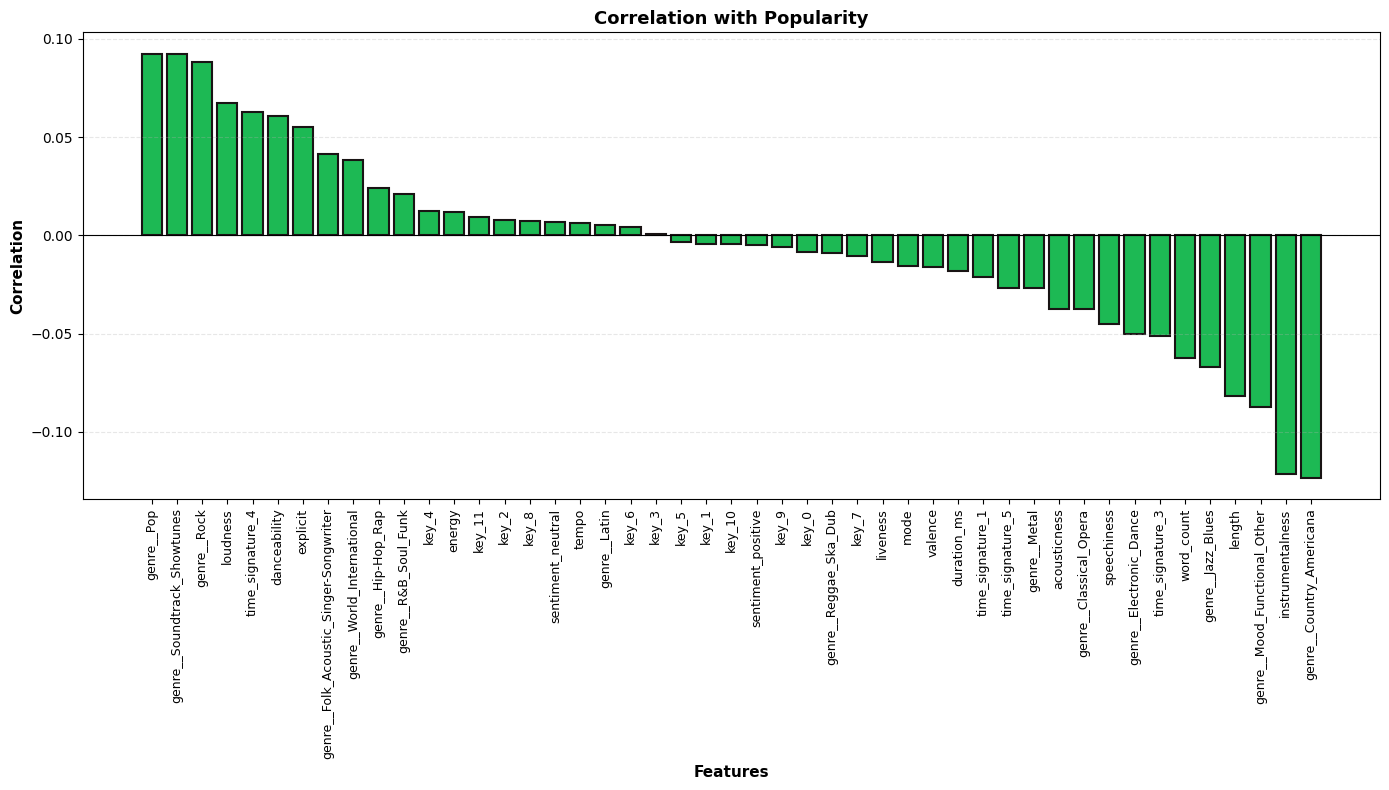

In [43]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Delete index column
if 'index' in numeric_cols:
    numeric_cols.remove('index')

# Get correlations with popularity
correlation_matrix = df[numeric_cols].corr()
popularity_corr = correlation_matrix['popularity'].drop('popularity').sort_values(ascending=False)

# Create figure - EXACTLY like the Accident Severity plot
fig, ax = plt.subplots(figsize=(14, 8))

# Spotify Green with Spotify Black border
spotify_green = '#1DB954'
spotify_black = '#191414'

# Create barplot with border
bars = ax.bar(range(len(popularity_corr)), popularity_corr.values, 
              color=spotify_green, edgecolor=spotify_black, linewidth=1.5)

# Formatting
ax.set_xticks(range(len(popularity_corr)))
ax.set_xticklabels(popularity_corr.index, rotation=90, fontsize=9)
ax.set_ylabel('Correlation', fontsize=11, fontweight='bold')
ax.set_xlabel('Features', fontsize=11, fontweight='bold')
ax.set_title('Correlation with Popularity', fontsize=13, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='y', alpha=0.3, linestyle='--')


# Display as table
print(popularity_corr)

# Save to CSV
popularity_corr.to_csv('figures/popularity_correlations.csv', header=['Correlation'])


plt.tight_layout()
plt.savefig('figures/popularity_correlations_barplot_simple.png', dpi=300, bbox_inches='tight')
plt.show()

## Data Preparation

### Remove Irrelevant Features

Normally, Feature Subset Selection plays a role in high dimensional spaces. For now we will select features with which we can compute the model. Later, we will have to do feature subset selection again to choose amongst the most valuable predictors. FORWARD SELECTION and BACKWARD ELIMINATION

Only use valuable features, hence, used  basic heuristic: nominal attributes removed with have more than p% identical values and which have more than p% different values

-> Hence, index and track_name are removed.

Remove False predictors: Songs popularity might be influenced by an artist name or album name.

-> Hence, artists and album_name are removed.

We keep track_id during all preprocessing steps for clarity. We will remove it before the DataMining step.

#### Irrelevant Features: False Predictors & Heuristics

In [18]:
# How do the textual attributes look like?
df.describe(include='object')

# Remove "artists", "album_name", "track_name" and "index" features (KEEP track_id for clarity)
df = df.drop(columns=['artists', 'album_name', 'index'])

In [19]:
# Check uniqueness of "time_signature"
# Hypothesis: most of the songs have time_signature 4

s = df["time_signature"]

time_sig_table = (
    s.value_counts(dropna=False)                    # count each value (including NaN)
     .sort_index()                                  # sort by the meter value (3,4,5,...)
     .rename_axis("time_signature")
     .reset_index(name="count")
)

time_sig_table["share"] = (time_sig_table["count"] / time_sig_table["count"].sum()).round(4)
time_sig_table

,time_signature,count,share
0,0,163,0.0014
1,1,973,0.0085
2,3,9195,0.0807
3,4,101843,0.8934
4,5,1826,0.0160


We want to further explore what characteristics songs of time_signature == 1 have and whether they can be considered genuine songs.
What should we do with entries that have time_signature == 1? Time_signature == 1 does not have a musical interpretation. Instead it is likely to be a missing value or time_signature could not be parsed. Nevertheless, other musical characteristcs stay inconspicuous.

In [20]:
# Group and compute mean
duration_by_ts = (
    df.groupby("time_signature", dropna=False)[["duration_ms", "tempo", "energy", "danceability", "loudness"]]
      .mean()
      .sort_values("time_signature")
)

print(duration_by_ts)

                  duration_ms       tempo    energy  danceability   loudness
time_signature                                                              
0               173239.932515    4.453074  0.132486      0.015258 -21.833135
1               208222.929085  108.215726  0.459715      0.423024 -12.878405
3               222407.808048  122.400176  0.451839      0.437493 -11.737859
4               229292.622664  122.609109  0.663831      0.582643  -7.813202
5               201312.196605  113.080267  0.486047      0.460160 -11.929061


In [21]:
# Verify that irrelevant features are removed
print('Dataset Info without Irrelevant Features:')
print(df.info())

Dataset Info without Irrelevant Features:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          114000 non-null  object 
 1   track_name        113999 non-null  object 
 2   popularity        114000 non-null  int64  
 3   duration_ms       114000 non-null  int64  
 4   explicit          114000 non-null  bool   
 5   danceability      114000 non-null  float64
 6   energy            114000 non-null  float64
 7   key               114000 non-null  int64  
 8   loudness          114000 non-null  float64
 9   mode              114000 non-null  int64  
 10  speechiness       114000 non-null  float64
 11  acousticness      114000 non-null  float64
 12  instrumentalness  114000 non-null  float64
 13  liveness          114000 non-null  float64
 14  valence           114000 non-null  float64
 15  tempo             114000 n

In the following several columns/features have to be looked at close since their meaning is not obvious at first sight:

- explicit = indicates whether the track contains explicit content (we might transform these into 0s and 1s)
- key = refers to the musical key (0 = C, ..., 11 = B) (this might be actually very interesting and since it is ordinal? otherwise nominal we should do one-hot-encoding)
- mode = modality (major = 1, minor = 0) (can be left as it is)
- tempo = estimated tempo in beats per minute (this might also be a relevant feature)
- time_signature = time signature of the track (e.g. 4 = 4/4) (also for that we should probably do one-hot encoding)


In [22]:
# Explore features that are not continuous and of type int64 or boolean: explicit, key, mode, time_signature 
# (track_id, popularity, duration_ms, track_genre are excluded since they will be explored separately)

print(df[["explicit", "key", "mode", "tempo", "time_signature"]].head(5))
print(df[["explicit", "key", "mode", "tempo", "time_signature"]].describe())

   explicit  key  mode    tempo  time_signature
0     False    1     0   87.917               4
1     False    1     1   77.489               4
2     False    0     1   76.332               4
3     False    0     1  181.740               3
4     False    2     1  119.949               4
                 key           mode          tempo  time_signature
count  114000.000000  114000.000000  114000.000000   114000.000000
mean        5.309140       0.637553     122.147837        3.904035
std         3.559987       0.480709      29.978197        0.432621
min         0.000000       0.000000       0.000000        0.000000
25%         2.000000       0.000000      99.218750        4.000000
50%         5.000000       1.000000     122.017000        4.000000
75%         8.000000       1.000000     140.071000        4.000000
max        11.000000       1.000000     243.372000        5.000000


#### Redundant Features: Correlation

Will be looked at in preprocessing PCA or feature subset selection

### Remove Outliers

In [23]:
# Define outlier conditions
under_1min = df['duration_ms'] < 60000
over_10min = df['duration_ms'] > 600000
tempo_zero = df['tempo'] == 0
ts_zero = df['time_signature'] == 0

# Dictionary for clean reporting
conditions = {
    "Songs shorter than 1 minute": under_1min,
    "Songs longer than 10 minutes": over_10min,
    "Songs with tempo = 0": tempo_zero,
    "Songs with time_signature = 0": ts_zero
}

# Output summary for each category
for label, condition in conditions.items():
    count = condition.sum()
    examples = df[condition].head(3)['track_name'].tolist()  # sample track names
    print(f"{label}: {count}")
    print(f"  Examples: {examples}\n")

# Combine all outlier rows
drop_clause = under_1min | over_10min | tempo_zero | ts_zero
drop_index = df[drop_clause].index

print(f"Total outliers removed: {len(drop_index)}")

# Drop rows
df = df.drop(drop_index)


Songs shorter than 1 minute: 851
  Examples: ['Jocelyn Flores - Acoustic Guitar', 'Cool Love 3', 'Canoeiro (vinheta)']

Songs longer than 10 minutes: 603
  Examples: ['Dove', 'Zombie', 'Qué Sabemos']

Songs with tempo = 0: 157
  Examples: ['The Departure', 'The End of Childhood (feat. Jack Liebeck)', 'Ferme Les Yeux']

Songs with time_signature = 0: 163
  Examples: ['Sanki Yapamadım', 'The Departure', 'The End of Childhood (feat. Jack Liebeck)']

Total outliers removed: 1608


### Missing Values

In [24]:
# Remove rows with Missing Values
print(df.isna().sum())

df = df.dropna()

# # Verify that missing values are removed
print('Dataset Info without Missing Values:')
df.info()

track_id            0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64
Dataset Info without Missing Values:
<class 'pandas.core.frame.DataFrame'>
Index: 112392 entries, 0 to 113999
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          112392 non-null  object 
 1   track_name        112392 non-null  object 
 2   popularity        112392 non-null  int64  
 3   duration_ms       112392 non-null  int64  
 4   explicit          112392 non-null  bool   
 5   danceability      112392 non-null  float64
 6   energy            112392 non-null  float64
 7   key        

## Data Engineering

#### Unsupported Data Types
Transform textual attributes to vector representations.

In our case: track_genre is a nominal attribute. We are doing multi-label one hot encoding (Ask: Does this work because it is not one hot but multiple columns up to a maximum of 6 genres)

Key, Mode, Explicit, Time_signature are "textual" features, too. At least their meaning is textual and they represent therefore a label. Hence we will one-hot encode them. Mode and Explicit do not need to be encoded since they are binary. Whereas Key and Time_signature need to be encoded.

### Boolean Values

In [25]:
# Converting Explicit Attribute from boolean to int
df["explicit"] = df["explicit"].astype(int)

# # Verify that we have converted this correctly
# print('Dataset Info without Irrelevant Features:')
# print(df.info())

### Multi-Hot-Encoding for track_genre

#### Genre summarization

In [26]:
# keep original_track_genre
# add new superior_track_genre

# dictionary with key as keywords for super genre mapping
# 15 superior genres -> list of source tags
category_keywords = {
    "Pop": [
        "pop","power-pop","synth-pop","indie-pop","k-pop","j-pop","mandopop","cantopop","j-idol"
    ],
    "Rock": [
        "rock","rock-n-roll","rockabilly","alt-rock","alternative","indie","emo","grunge",
        "psych-rock","punk","punk-rock","hard-rock","goth","garage","j-rock"
    ],
    "Hip-Hop/Rap": [
        "hip-hop"
    ],
    "Electronic/Dance": [
        "electronic","edm","electro","dance","club","house","deep-house","progressive-house",
        "chicago-house","techno","detroit-techno","minimal-techno","trance","hardstyle",
        "drum-and-bass","breakbeat","dubstep","idm","j-dance","ambient","trip-hop","industrial"
    ],
    "Metal": [
        "metal","heavy-metal","black-metal","death-metal","metalcore","grindcore","hardcore"
    ],
    "Latin": [
        "latin","latino","reggaeton","salsa","samba","tango","pagode","forro","mpb","sertanejo"
    ],
    "R&B/Soul/Funk": [
        "r-n-b","soul","funk","gospel","groove"
    ],
    "Jazz/Blues": [
        "jazz","blues"
    ],
    "Country/Americana": [
        "country","honky-tonk","bluegrass"
    ],
    "Folk/Acoustic/Singer-Songwriter": [
        "folk","acoustic","singer-songwriter","songwriter","guitar"
    ],
    "Classical/Opera": [
        "classical","opera","piano"
    ],
    "Reggae/Ska/Dub": [
        "reggae","ska","dub","dancehall"
    ],
    "Soundtrack/Showtunes": [
        "show-tunes","disney","anime","pop-film"
    ],
    "World/International": [
        "world-music","brazil","french","german","spanish","swedish","turkish","malay",
        "iranian","indian","british"
    ],
    "Mood/Functional/Other": [
        "chill","happy","party","romance","sad","sleep","study","children","kids","new-age","comedy"
    ],
}

# Invert to tag -> super-genre map
super_genre_map = {
    tag: cat
    for cat, tags in category_keywords.items()
    for tag in tags
}


#### Remove Duplicates

In [27]:
# Find duplicates in df[track_id]
print("Duplicates track_id", sum(df["track_id"].duplicated()))
print("Duplicates whole dataframe", sum(df.duplicated()))

print("Duplicates track_id & track_genre", sum(df[["track_id", "track_genre"]].duplicated()))

# Do this for all combinations to show, that these are real duplicates and not (superficial duplicates as with the track_genre)
print("Duplicates track_id & track_genre & 3rd", sum(df[["track_id", "track_genre", "time_signature"]].duplicated()))

# --> 24259 duplicates in "track_id", 450 in whole dataset, combination of track_id and track_genre again 450
# --> Consequently, 450 true duplicates, rest alternations of track_genre

# Find all superior genres for one track_id (a df with columns track_id and superior_track_genre)
print("Unique genres:", df["track_genre"].unique())
print("Number of unique genres: ", len(df["track_genre"].unique()))


Duplicates track_id 24126
Duplicates whole dataframe 432
Duplicates track_id & track_genre 432
Duplicates track_id & track_genre & 3rd 432
Unique genres: ['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
 'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
 'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
 'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
 'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
 'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
 'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
 'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
 'progressive

In [28]:
# df with track_id and track_genre
df_track_id_genre = df[["track_id", "track_genre"]]

# df with track_id, track_genre and genre_super
# Apply (single-tag per row). For unknown tags fall back to World/International or Other.
df_super_long = df_track_id_genre
df_super_long["genre_super"] = df_track_id_genre["track_genre"].map(super_genre_map).fillna("World/International")

# df with track_id and genre_super
df_super_long = df_super_long.drop(columns=["track_genre"])
print(df_super_long.head(5))


                 track_id                      genre_super
0  5SuOikwiRyPMVoIQDJUgSV  Folk/Acoustic/Singer-Songwriter
1  4qPNDBW1i3p13qLCt0Ki3A  Folk/Acoustic/Singer-Songwriter
2  1iJBSr7s7jYXzM8EGcbK5b  Folk/Acoustic/Singer-Songwriter
3  6lfxq3CG4xtTiEg7opyCyx  Folk/Acoustic/Singer-Songwriter
4  5vjLSffimiIP26QG5WcN2K  Folk/Acoustic/Singer-Songwriter


/var/folders/39/jf8nndmx4v5ft98v1kjbx6880000gn/T/ipykernel_53340/2712052728.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_super_long["genre_super"] = df_track_id_genre["track_genre"].map(super_genre_map).fillna("World/International")


#### Multi-Hot Encoding for Track Genre

We decided to not use the OneHotEncoder from the sklearn.preprocessing package since our data is multi-label. OneHotEncoder expects one label per category but we have multiple labels per category (aka track_id). So we would have to explode the genres and then aggregate anyway. Additionally our dataframe is static and we are not building a full ML Pipeline for automated retraining. Hence, we stick with the manual solution with pandas. Regardless the technique, we will have a dataframe with genres as columns and binary values indicating to which genres a song belongs.

In [29]:
# remove exact duplicates
df_super_long = df_super_long.drop_duplicates()

# create the one hot encoding for multi-label as a wide dataframe
df_wide = (
    df_super_long.assign(val=1)
    .pivot_table(index="track_id", columns="genre_super", values="val",
                 aggfunc="max", fill_value=0)
    .astype("int8")
)

df_wide.columns = [f"genre__{c.replace(' ', '_').replace('/', '_')}" for c in df_wide.columns]
df_wide.index.name = "track_id"  # ensure the index has the right name
df_wide = df_wide.reset_index()  # now it becomes a proper column

print(df_wide.head(5))

                 track_id  genre__Classical_Opera  genre__Country_Americana  \
0  0000vdREvCVMxbQTkS888c                       0                         0   
1  000CC8EParg64OmTxVnZ0p                       0                         0   
2  000Iz0K615UepwSJ5z2RE5                       0                         0   
3  000RDCYioLteXcutOjeweY                       0                         0   
4  000qpdoc97IMTBvF8gwcpy                       0                         0   

   genre__Electronic_Dance  genre__Folk_Acoustic_Singer-Songwriter  \
0                        0                                       0   
1                        1                                       0   
2                        1                                       0   
3                        0                                       0   
4                        1                                       0   

   genre__Hip-Hop_Rap  genre__Jazz_Blues  genre__Latin  genre__Metal  \
0                   0           

In [30]:
# join back to original dataframe df and drop duplicates
base = df.drop(columns=["track_genre"]).copy()
base = base.drop_duplicates(subset=["track_id"])

# quick sanity check before merging
print("Length base:", len(base))
print("Length df_wide:", len(df_wide))

# merge with how=left to guarantee all base rows will be kept
df_final = base.merge(df_wide, on="track_id", how="left")

print("Length final dataset:", len(df_final))

Length base: 88266
Length df_wide: 88266
Length final dataset: 88266


In [31]:
# Quick Sanity checks
# 1) Uniqueness before merge (protects against row explosion)
assert base["track_id"].is_unique, "base has duplicate track_id"
assert df_wide["track_id"].is_unique, "df_wide has duplicate track_id"

# 2) No unexpected NaNs in the multi-hot columns after merge
genre_cols = [c for c in df_final.columns if c.startswith("genre__")]
na_counts = df_final[genre_cols].isna().sum().sum()
print("NaNs in genre columns:", na_counts)

# If any NaNs (shouldn’t happen if pivot used fill_value=0), fix:
# df_final[genre_cols] = df_final[genre_cols].fillna(0).astype("int8")

# 3) All values are 0/1
bad_vals = set(df_final[genre_cols].stack().unique()) - {0, 1}
print("Non {0,1} values present?:", bool(bad_vals), bad_vals)

# 4) No track has all-zero vector (would indicate unmapped genre)
all_zero_tracks = (df_final[genre_cols].sum(axis=1) == 0).sum()
print("Tracks with no super-genre assigned:", all_zero_tracks)

df_final["amount_genres"] = df_final[genre_cols].sum(axis=1)
print("Maximum of genres a song belonged:", max(df_final["amount_genres"]))

# 5) Basic distribution & sparsity (quick glance)
col_sums = df_final[genre_cols].sum().sort_values(ascending=False)
print(col_sums.head(10))

# 6) Optional: memory/dtype tidy-up
print(df_final[genre_cols].dtypes.unique())
# If needed:
# df_final[genre_cols] = df_final[genre_cols].astype("int8")


NaNs in genre columns: 0
Non {0,1} values present?: False set()
Tracks with no super-genre assigned: 0
Maximum of genres a song belonged: 6
genre__Electronic_Dance         18863
genre__World_International      12706
genre__Rock                     11957
genre__Mood_Functional_Other    10157
genre__Pop                       8714
genre__Latin                     8004
genre__Metal                     6343
genre__R&B_Soul_Funk             4668
genre__Reggae_Ska_Dub            3943
genre__Soundtrack_Showtunes      3788
dtype: int64
[dtype('int8')]


In [32]:
# set df_final to df
df = df_final
df.head(3)

,track_id,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,...,genre__Latin,genre__Metal,genre__Mood_Functional_Other,genre__Pop,genre__R&B_Soul_Funk,genre__Reggae_Ska_Dub,genre__Rock,genre__Soundtrack_Showtunes,genre__World_International,amount_genres
0,5SuOikwiRyPMVoIQDJUgSV,Comedy,73,230666,0,0.676,0.461,1,-6.746,0,...,0,0,0,1,0,0,0,0,0,2
1,4qPNDBW1i3p13qLCt0Ki3A,Ghost - Acoustic,55,149610,0,0.420,0.166,1,-17.235,1,...,0,0,1,0,0,0,0,0,0,2
2,1iJBSr7s7jYXzM8EGcbK5b,To Begin Again,57,210826,0,0.438,0.359,0,-9.734,1,...,0,0,0,0,0,0,0,0,0,1


### One-Hot Encoding for Key and Time Signature
Since trees do not use distances we will stick with OHE. Alternatively, we could have used cyclic encoding (with sin and cos). With that we would get a compact representation that respects musical adjacency. This might be useful if we later test linear regression, ridge/lasso, SVM, k-NN or neural nets. For our current scope One Hot Encoding is the optimal choice.

In [33]:
# use OHE from scikit package for key and time signature
# OneHotEncoder: fit encoder on the two categorical columns (later test against difference for 'infrequent_if_exist)
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False, dtype=int)
encoded = enc.fit_transform(df[["key", "time_signature"]])

# Build a DataFrame with readable column names
ohe_cols = enc.get_feature_names_out(["key", "time_signature"])
encoded_df = pd.DataFrame(encoded, columns=ohe_cols, index=df.index)

# Replace the original columns with their OHE versions
df_simple = pd.concat([df.drop(columns=["key", "time_signature"]), encoded_df], axis=1)

# PROBLEM SOLVED: df is the main dataframe again
df = df_simple
df.head()
 

,track_id,track_name,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,...,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,5SuOikwiRyPMVoIQDJUgSV,Comedy,73,230666,0,0.676,0.4610,-6.746,0,0.1430,...,0,0,0,0,0,0,0,0,1,0
1,4qPNDBW1i3p13qLCt0Ki3A,Ghost - Acoustic,55,149610,0,0.420,0.1660,-17.235,1,0.0763,...,0,0,0,0,0,0,0,0,1,0
2,1iJBSr7s7jYXzM8EGcbK5b,To Begin Again,57,210826,0,0.438,0.3590,-9.734,1,0.0557,...,0,0,0,0,0,0,0,0,1,0
3,6lfxq3CG4xtTiEg7opyCyx,Can't Help Falling In Love,71,201933,0,0.266,0.0596,-18.515,1,0.0363,...,0,0,0,0,0,0,0,1,0,0
4,5vjLSffimiIP26QG5WcN2K,Hold On,82,198853,0,0.618,0.4430,-9.681,1,0.0526,...,0,0,0,0,0,0,0,0,1,0


### Sentiment Analysis on Track_Title

Transform Track ID in several ways to include it in our prediction.

Track-ID Variables:
- Total length/character count
- Word count
- Special characters?
- Sentiment Analysis
- Emotional categories

In [34]:
df['length'] = df['track_name'].str.len()
df['word_count'] = df['track_name'].str.split().str.len()

print(df[['track_name', 'length', 'word_count']])


                       track_name  length  word_count
0                          Comedy       6           1
1                Ghost - Acoustic      16           3
2                  To Begin Again      14           3
3      Can't Help Falling In Love      26           5
4                         Hold On       7           2
...                           ...     ...         ...
88261         Sleep My Little Boy      19           4
88262            Water Into Light      16           3
88263              Miss Perfumado      14           2
88264                     Friends       7           1
88265                   Barbincor       9           1

[88266 rows x 3 columns]


In [35]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()


# Function for sentiment
def get_sentiment_vader(text):
    scores = analyzer.polarity_scores(text)
    compound = scores['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply sentiment analysis
df['sentiment'] = df['track_name'].apply(get_sentiment_vader)
print(df[["track_name", "sentiment"]])


                       track_name sentiment
0                          Comedy  positive
1                Ghost - Acoustic  negative
2                  To Begin Again   neutral
3      Can't Help Falling In Love  positive
4                         Hold On   neutral
...                           ...       ...
88261         Sleep My Little Boy   neutral
88262            Water Into Light   neutral
88263              Miss Perfumado  negative
88264                     Friends  positive
88265                   Barbincor   neutral

[88266 rows x 2 columns]


In [36]:
# Drop sentiments if they are already there (to not have multiple one-hot encoded duplicates)
df = df.drop(columns=[col for col in df.columns if col.startswith('sentiment_')], errors='ignore')

# One-hot encode sentiment column (this creates 0/1 columns)
sentiment_dummies = pd.get_dummies(df['sentiment'], prefix='sentiment', dtype=int, drop_first=True)

# Concatenate one-hot encoded columns back into dataframe
df = pd.concat([df, sentiment_dummies], axis=1)

# Optional: drop original 'sentiment' if you don't need the text labels
df.drop(columns=['sentiment'], inplace=True)

# Check result
print(df[["track_name", "sentiment_positive", "sentiment_neutral"]].head())

## Negative is both dummies 0


                   track_name  sentiment_positive  sentiment_neutral
0                      Comedy                   1                  0
1            Ghost - Acoustic                   0                  0
2              To Begin Again                   0                  1
3  Can't Help Falling In Love                   1                  0
4                     Hold On                   0                  1


In [37]:
df.head()

,track_id,track_name,popularity,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,...,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5,length,word_count,sentiment_neutral,sentiment_positive
0,5SuOikwiRyPMVoIQDJUgSV,Comedy,73,230666,0,0.676,0.4610,-6.746,0,0.1430,...,0,0,0,0,1,0,6,1,0,1
1,4qPNDBW1i3p13qLCt0Ki3A,Ghost - Acoustic,55,149610,0,0.420,0.1660,-17.235,1,0.0763,...,0,0,0,0,1,0,16,3,0,0
2,1iJBSr7s7jYXzM8EGcbK5b,To Begin Again,57,210826,0,0.438,0.3590,-9.734,1,0.0557,...,0,0,0,0,1,0,14,3,1,0
3,6lfxq3CG4xtTiEg7opyCyx,Can't Help Falling In Love,71,201933,0,0.266,0.0596,-18.515,1,0.0363,...,0,0,0,1,0,0,26,5,0,1
4,5vjLSffimiIP26QG5WcN2K,Hold On,82,198853,0,0.618,0.4430,-9.681,1,0.0526,...,0,0,0,0,1,0,7,2,1,0


### Unbalanced Class Distribution
Our outcome variable is continuous, so there is not really a class imbalance. Most of our predictor variables are continuous, too, however we do use genres which might be distributed inequally.

There are way more tracks labeled as rock, pop, world_international, latin, electronic_dance, mood_functional_other. 

In [38]:
# columns
features = ["popularity","danceability","energy","loudness","speechiness", "duration_ms"]
genre_cols = [c for c in df.columns if c.startswith("genre_")]  # or pass your explicit list

# long format → filter rows where the genre flag == 1 → mean by genre
long = df[features + genre_cols].melt(
    id_vars=features, value_vars=genre_cols,
    var_name="genre", value_name="flag"
)
summary = (long[long["flag"] == 1]
           .groupby("genre")[features]
           .mean()
           .sort_values("popularity", ascending=False))

# add counts per genre and share of dataset
counts = df[genre_cols].sum().rename("n_tracks")
summary = summary.join(counts, on="genre")
summary["share_%"] = 100 * summary["n_tracks"] / len(df)

summary.reset_index()


,genre,popularity,danceability,energy,loudness,speechiness,duration_ms,n_tracks,share_%
0,genre__Soundtrack_Showtunes,42.360876,0.520307,0.504339,-10.125147,0.082596,218471.058606,3788,4.291573
1,genre__Pop,39.115446,0.575121,0.655173,-7.081615,0.060949,230140.993803,8714,9.872431
2,genre__Hip-Hop_Rap,37.997976,0.736080,0.682104,-5.995789,0.129932,206708.891700,988,1.119344
3,genre__Rock,37.947980,0.527456,0.695715,-7.110491,0.064906,216717.267709,11957,13.546552
4,genre__Folk_Acoustic_Singer-Songwriter,37.454989,0.555113,0.434556,-10.502343,0.051500,219533.253254,3688,4.178279
5,genre__World_International,35.280104,0.567709,0.607267,-8.811255,0.081263,240496.964741,12706,14.395124
6,genre__R&B_Soul_Funk,35.199443,0.594690,0.634043,-7.083354,0.084511,237267.723008,4668,5.288560
7,genre__Latin,33.708521,0.625056,0.664559,-7.006199,0.074363,216923.118191,8004,9.068044
8,genre__Reggae_Ska_Dub,32.489221,0.658578,0.730774,-5.925630,0.116990,215814.770226,3943,4.467179
9,genre__Metal,31.367649,0.405089,0.883405,-5.678939,0.104453,234501.019234,6343,7.186233


### Different Scales: Normalization
Since we are computing a Regression Tree we do not need to scale the values between 0 and 1. We could implement it to guarantee consistency across models (e.g. comparing with model trees). In a model tree we would need to scale the values so the penalty in Lasso or Ridge regression stays fairly. However, so far we are asked to compute a model which interpolates and not one that extrapolates as model trees would we skip scaling.

### Sampling
Our training data is already a sample.
Maybe stratified sampling by genre to ensure all genres are proportionally represented in each fold. Avoids overfitting to popular genres. (Do we really need this? Since we are doing a Regression Tree we split at genre probably?? ASK). Also if necessary, should we sample after or before genre summarization?

## Save Preprocessing

In [39]:
# remove track_id after preprocessing
df = df.drop(columns=["track_id", "track_name", "amount_genres"])

### Sanity Checks

In [40]:
# correct amount of columns
print(len(df.columns))
print(df.columns)

48
Index(['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'genre__Classical_Opera',
       'genre__Country_Americana', 'genre__Electronic_Dance',
       'genre__Folk_Acoustic_Singer-Songwriter', 'genre__Hip-Hop_Rap',
       'genre__Jazz_Blues', 'genre__Latin', 'genre__Metal',
       'genre__Mood_Functional_Other', 'genre__Pop', 'genre__R&B_Soul_Funk',
       'genre__Reggae_Ska_Dub', 'genre__Rock', 'genre__Soundtrack_Showtunes',
       'genre__World_International', 'key_0', 'key_1', 'key_2', 'key_3',
       'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5', 'length', 'word_count', 'sentiment_neutral',
       'sentiment_positive'],
      dtype='object')


In [41]:
# length of dataset
print(len(df))

88266


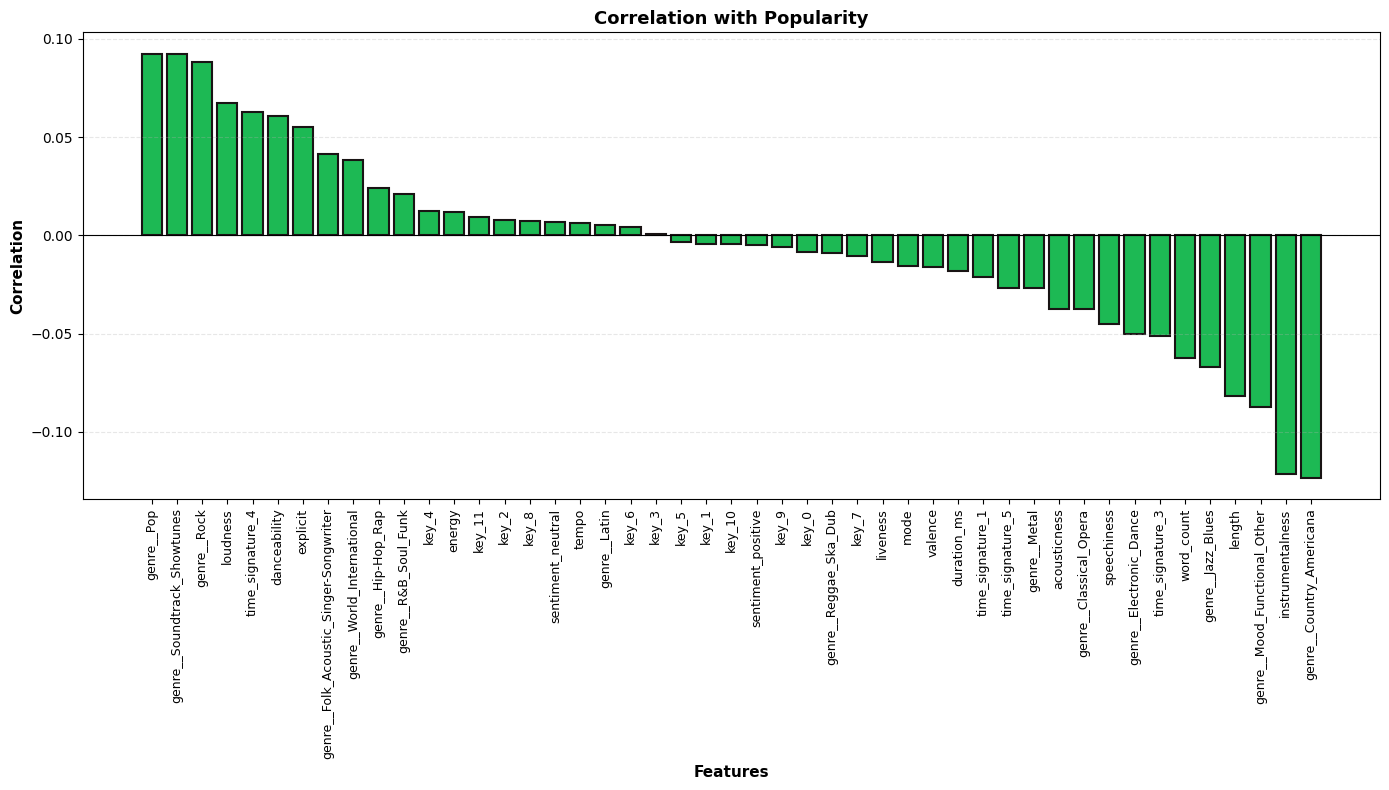

In [42]:
# Full correlation figure:


# Select only numeric columns
numeric_cols = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
                'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'genre__Classical_Opera',
                'genre__Country_Americana', 'genre__Electronic_Dance',
                'genre__Folk_Acoustic_Singer-Songwriter', 'genre__Hip-Hop_Rap',
                'genre__Jazz_Blues', 'genre__Latin', 'genre__Metal',
                'genre__Mood_Functional_Other', 'genre__Pop', 'genre__R&B_Soul_Funk',
                'genre__Reggae_Ska_Dub', 'genre__Rock', 'genre__Soundtrack_Showtunes',
                'genre__World_International', 'key_0', 'key_1', 'key_2', 'key_3',
                'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
                'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4',
                'time_signature_5', 'length', 'word_count', 'sentiment_neutral',
                'sentiment_positive']


# Get correlations with popularity
correlation_matrix = df[numeric_cols].corr()
popularity_corr = correlation_matrix['popularity'].drop('popularity').sort_values(ascending=False)


# Create figure - EXACTLY like the Accident Severity plot
fig, ax = plt.subplots(figsize=(14, 8))


# Spotify Green with Spotify Black border
spotify_green = '#1DB954'
spotify_black = '#191414'


# Create barplot with border
bars = ax.bar(range(len(popularity_corr)), popularity_corr.values, 
              color=spotify_green, edgecolor=spotify_black, linewidth=1.5)


# Formatting
ax.set_xticks(range(len(popularity_corr)))
ax.set_xticklabels(popularity_corr.index, rotation=90, fontsize=9)
ax.set_ylabel('Correlation', fontsize=11, fontweight='bold')
ax.set_xlabel('Features', fontsize=11, fontweight='bold')
ax.set_title('Correlation with Popularity', fontsize=13, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='y', alpha=0.3, linestyle='--')


plt.tight_layout()
plt.savefig('figures/popularity_correlations_barplot.png', dpi=300, bbox_inches='tight')
plt.show()

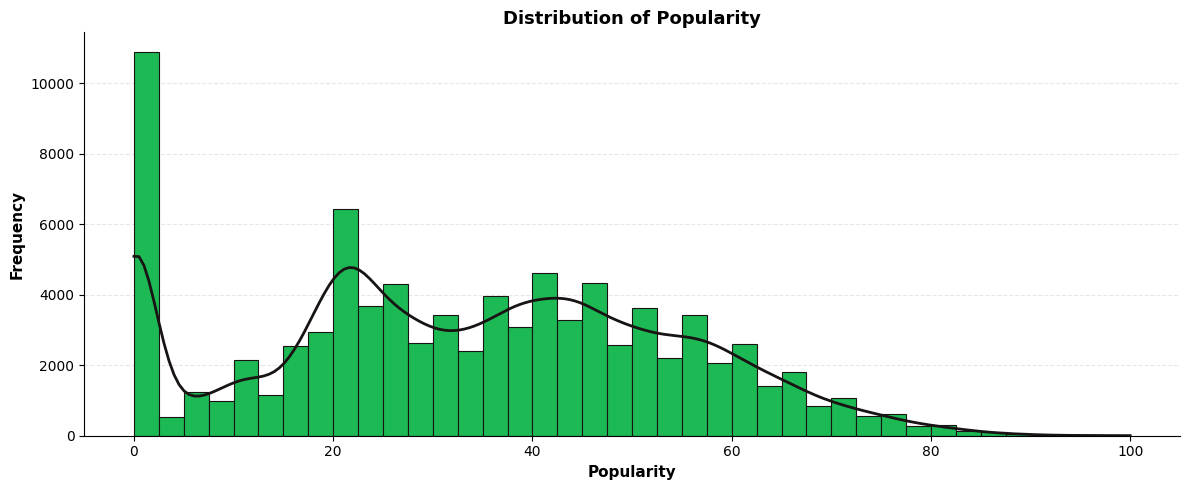

✓ Figure saved to 'figures/popularity_distribution.png'


In [45]:
# Create figure - flatter (smaller height)
fig, ax = plt.subplots(figsize=(12, 5))

# Spotify colors
spotify_green = '#1DB954'
spotify_black = '#191414'

# Create histogram with Spotify green
n, bins, patches = ax.hist(df['popularity'], bins=40, color=spotify_green, edgecolor=spotify_black, linewidth=0.8)

# Add KDE trend line in Spotify black
kde = stats.gaussian_kde(df['popularity'])
x_range = np.linspace(df['popularity'].min(), df['popularity'].max(), 200)
ax.plot(x_range, kde(x_range) * len(df['popularity']) * (bins[1] - bins[0]), 
        color=spotify_black, linewidth=2, label='Density')

# Formatting
ax.set_xlabel('Popularity', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Popularity', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('figures/popularity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Figure saved to 'figures/popularity_distribution.png'")


### Save Preprocessed data

In [30]:
save_step(df, "df_preprocessed")

Saved df_preprocessed.csv


### Save Data without Popularity Score Zero

In [31]:
# Dropping 0 popularity of zero_train and zero_test
len_with_zeros = len(df)
df_no_zero = df[df["popularity"] > 0].copy()
len_no_zeros = len(df_no_zero)

print(f"With popularity score of zeros we have {len_with_zeros} entries, \n without zeros we have {len_no_zeros}entries")
print(f"In total {len_with_zeros - len_no_zeros} had a popularity score of o and thus were deleted")
save_step(df_no_zero, "df_no_zero_preprocessed")

With popularity score of zeros we have 88266 entries, 
 without zeros we have 78943entries
In total 9323 had a popularity score of o and thus were deleted
Saved df_no_zero_preprocessed.csv
